In [1]:
%matplotlib inline

# Cell-segmentation for H&E stains

This example shows how to use processing and segmentation functions to
segment images with H&E stains.

For a general example of how to use `squidpy.im.segment`, see
`sphx_glr_auto_examples_image_compute_segment_fluo.py`.

Note that we only provide a basic built-in segmentation model. If you
require precise cell-segmentation and cell-counts, you might want to add
more pre-processing and/or use a pre-trained model to do the
segmentation (using `squidpy.im.SegmentationCustom`).

::: seealso
-   `sphx_glr_auto_examples_image_compute_segment_fluo.py` for an
    example on how to calculate a cell-segmentation of a fluorescence
    image.
-   [Nuclei Segmentation using
    Cellpose](../../external_tutorials/tutorial_cellpose_segmentation.ipynb)
    for a tutorial on using Cellpose as a custom segmentation function.
-   [Nuclei Segmentation using
    StarDist](../../external_tutorials/tutorial_stardist.ipynb) for a
    tutorial on using StarDist as a custom segmentation function.
:::


In [2]:
import squidpy as sq

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# load the H&E stained tissue image and crop to a smaller segment
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)

In [3]:
img

ImageContainer[shape=(3527, 3527), layers=['image']]

In [4]:
crop

ImageContainer[shape=(1000, 1000), layers=['image']]

Before segmenting the image, we smooth it using `squidpy.im.process`.


In [11]:
# smooth image
sq.im.process(crop, layer="image", method="smooth", sigma=4)
crop

ImageContainer[shape=(1000, 1000), layers=['image', 'image_smooth', 'segmented_watershed']]

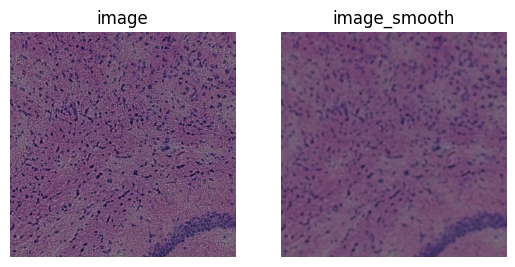

In [5]:
# plot the result
fig, axes = plt.subplots(1, 2)
for layer, ax in zip(["image", "image_smooth"], axes):
    crop.show(layer, ax=ax)
    ax.set_title(layer)

We will use channel 0 to do the segmentation, as this channel contains
most of the nuclei information within an H&E stain. Instead of using
automatic threshold with [Otsu\'s
method](https://en.wikipedia.org/wiki/Otsu%27s_method), we will define a
manual fixed threshold. Note that using Otsu\'s method to determine the
threshold also yields good results.

Judging by peak in the histogram and the thresholded example image, a
threshold of 90, seems to be a good choice for this example.


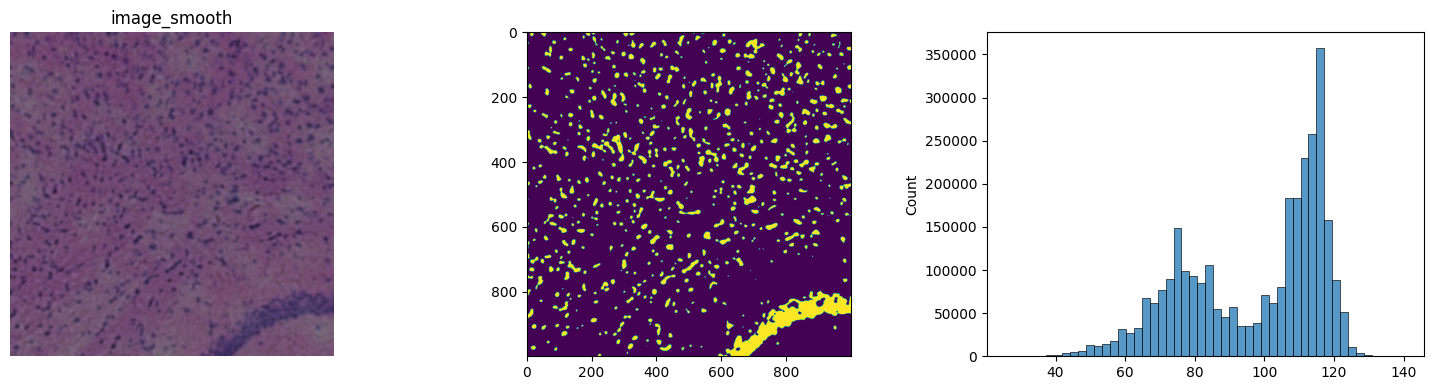

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
crop.show("image_smooth", cmap="gray", ax=axes[0])
axes[1].imshow(crop["image_smooth"][:, :, 0, 0] < 90)
_ = sns.histplot(np.array(crop["image_smooth"]).flatten(), bins=50, ax=axes[2])
plt.tight_layout()

We use `squidpy.im.segment` with `method = 'watershed'` to do the
segmentation. Since, opposite to the fluorescence DAPI stain, in the H&E
stain nuclei appear darker, we need to indicate to the model that it
should treat lower-intensity values as foreground. We do this by
specifying the `geq = False` in the `kwargs`.


> IDF: This is wrong. DAPI stains only the nucleus and is therefore a proxy for the cell location and is considered the 'foreground'. In H&E stains, the hematoxylin also stains the nucleus but the eosin stains the extracellular matrix. It is in a sense the negative image of the cell and therefore, the stains are treated as the 'background'.

In [7]:
sq.im.segment(img=crop, layer="image_smooth", method="watershed", thresh=90, geq=False)

> IDF: Let's also experiment with the threshold and show the negative

In [31]:
sq.im.segment(img=crop, 
              layer="image_smooth", 
              layer_added='segmented_watershed_inv', 
              method="watershed", 
              thresh=90, 
              geq=True)

sq.im.segment(img=crop, 
              layer="image_smooth", 
              layer_added='segmented_watershed_thresh60', 
              method="watershed", 
              thresh=60, 
              geq=False)

sq.im.segment(img=crop, 
              layer="image_smooth", 
              layer_added='segmented_watershed_thresh100', 
              method="watershed", 
              thresh=100, 
              geq=False)

In [18]:
crop

ImageContainer[shape=(1000, 1000), layers=['image', 'image_smooth', 'segmented_watershed', 'segmented_watershed_inv', 'segmented_watershed_thresh120', 'segmented_watershed_thresh60']]

The segmented crop is saved in the layer
[segmented_watershed]{.title-ref}. This behavior can be changed with the
arguments `copy` and `layer_added`. The result of the segmentation is a
label image that can be used to extract features like the number of
cells from the image.


ImageContainer[shape=(1000, 1000), layers=['image', 'image_smooth', 'segmented_watershed', 'segmented_watershed_inv', 'segmented_watershed_thresh100', 'segmented_watershed_thresh120', 'segmented_watershed_thresh60']]
Number of segments in crop thresh=60: 161
Number of segments in crop thresh=90: 1182
Number of segments in crop thresh=100: 1471


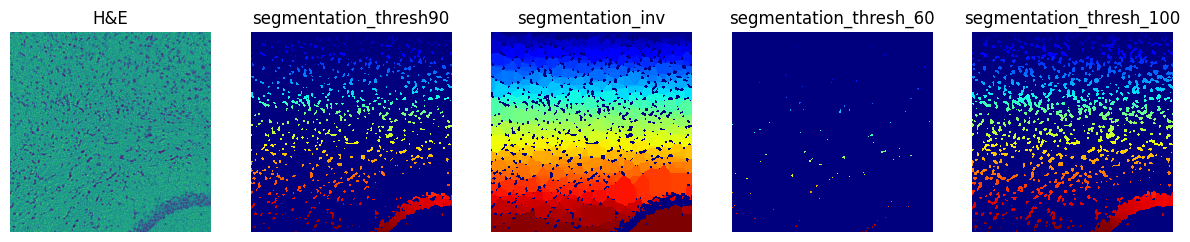

In [34]:
print(crop)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation_thresh90")
crop.show("segmented_watershed_inv", cmap="jet", interpolation="none", ax=axes[2])
_ = axes[2].set_title("segmentation_inv")
crop.show("segmented_watershed_thresh60", cmap="jet", interpolation="none", ax=axes[3])
_ = axes[3].set_title("segmentation_thresh_60")
crop.show("segmented_watershed_thresh100", cmap="jet", interpolation="none", ax=axes[4])
_ = axes[4].set_title("segmentation_thresh_100")

print(f"Number of segments in crop thresh=60: {len(np.unique(crop['segmented_watershed_thresh60']))}")
print(f"Number of segments in crop thresh=90: {len(np.unique(crop['segmented_watershed']))}")
print(f"Number of segments in crop thresh=100: {len(np.unique(crop['segmented_watershed_thresh100']))}")